# Projet 8: Déployez un modèle dans le cloud 

 
Développer dans un environnement Big Data (AWS) une première chaîne de traitement des données  
Preprocessing et une étape de réduction de dimension (ACP).

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.image import ImageSchema

import sagemaker_pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [2]:
import numpy as np 
import pandas as pd 


In [3]:
pip install tensorflow

     |████████████████████████████████| 458.3 MB 5.1 kB/s             
     |████████████████████████████████| 65 kB 342 kB/s             
     |████████████████████████████████| 42 kB 1.7 MB/s             
     |████████████████████████████████| 5.6 MB 57.9 MB/s            
     |████████████████████████████████| 462 kB 59.6 MB/s            
     |████████████████████████████████| 1.3 MB 38.9 MB/s            
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 132 kB 61.4 MB/s            
     |████████████████████████████████| 4.1 MB 33.9 MB/s            
     |████████████████████████████████| 4.9 MB 39.5 MB/s            
     |████████████████████████████████| 781 kB 61.1 MB/s            
     |████████████████████████████████| 152 kB 73.6 MB/s            
     |████████████████████████████████| 97 kB 1.4 MB/s             
     |████████████████████████████████| 155 kB 77.7 MB/s            
     |████████████████

# Traitement des images

In [5]:
spark

In [6]:
print (pd.__version__)

1.1.5


In [7]:
from pyspark.sql.types import ArrayType,IntegerType,FloatType
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import udf
from pyspark.sql.functions import split
import numpy as np

#https://stackoverflow.com/questions/60568744/pyspark-spark-dataframe-convert-imageschema-column-to-a-ndarray-as-a-new-colu
data_location = "s3a://ocprojet08/**"

imagesdf = spark.read.format("image").load(data_location, inferschema=True)

In [8]:
imagesdf = imagesdf.withColumn("FileName", regexp_replace('image.origin', 'dbfs:/mnt/images/', '')) 
split_col =split(imagesdf['FileName'], '/')
imagesdf = imagesdf.withColumn('label', split_col.getItem(3))
imagesdf.show(20)

+--------------------+--------------------+----------+
|               image|            FileName|     label|
+--------------------+--------------------+----------+
|[s3a://ocprojet08...|s3a://ocprojet08/...|cucumber_1|
|[s3a://ocprojet08...|s3a://ocprojet08/...|cucumber_1|
|[s3a://ocprojet08...|s3a://ocprojet08/...|cucumber_1|
|[s3a://ocprojet08...|s3a://ocprojet08/...|cucumber_1|
|[s3a://ocprojet08...|s3a://ocprojet08/...|cucumber_1|
|[s3a://ocprojet08...|s3a://ocprojet08/...|cucumber_1|
|[s3a://ocprojet08...|s3a://ocprojet08/...|cucumber_1|
|[s3a://ocprojet08...|s3a://ocprojet08/...|cucumber_1|
|[s3a://ocprojet08...|s3a://ocprojet08/...|cucumber_1|
|[s3a://ocprojet08...|s3a://ocprojet08/...|cucumber_1|
|[s3a://ocprojet08...|s3a://ocprojet08/...|cucumber_1|
|[s3a://ocprojet08...|s3a://ocprojet08/...|cucumber_1|
|[s3a://ocprojet08...|s3a://ocprojet08/...|cucumber_1|
|[s3a://ocprojet08...|s3a://ocprojet08/...|cucumber_1|
|[s3a://ocprojet08...|s3a://ocprojet08/...|cucumber_1|
|[s3a://oc

In [9]:
df_im=imagesdf.select('image.origin',"image.height","image.width","image.nChannels", "image.mode", "image.data",'label')
df_im.show(5)

+--------------------+------+-----+---------+----+--------------------+----------+
|              origin|height|width|nChannels|mode|                data|     label|
+--------------------+------+-----+---------+----+--------------------+----------+
|s3a://ocprojet08/...|   798|  323|        3|  16|[FF FF FF FF FF F...|cucumber_1|
|s3a://ocprojet08/...|   803|  325|        3|  16|[FF FF FF FF FF F...|cucumber_1|
|s3a://ocprojet08/...|   798|  324|        3|  16|[FF FF FF FF FF F...|cucumber_1|
|s3a://ocprojet08/...|   803|  326|        3|  16|[FF FF FF FF FF F...|cucumber_1|
|s3a://ocprojet08/...|   797|  325|        3|  16|[FF FF FF FF FF F...|cucumber_1|
+--------------------+------+-----+---------+----+--------------------+----------+
only showing top 5 rows



In [10]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

model = ResNet50(
    include_top=False,
    weights=None,
    pooling='max',
    input_shape=(100, 100, 3))
model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Extraction des features

In [11]:
from keras.preprocessing import image
from PIL import Image
#https://stackoverflow.com/questions/36205481/read-file-content-from-s3-bucket-with-boto3
#projet6 openclassrooms
import boto3
# Get resources stored in AWS S3 service
s3 = boto3.resource('s3')
bucket = s3.Bucket('ocprojet08')
resnet_features=[]
for bucket_key in bucket.objects.limit(1000):
    path=bucket_key.key
    obj = bucket.Object(path)
    image_x = obj.get()['Body']
    img = Image.open(image_x).resize ((100, 100))
    
    # convert image to  array
    x = image.img_to_array(img).reshape((-1,100,100,3))
    x=np.array(x)
   
    # preprocess input
    x = preprocess_input(x)
    
    resnet_feature = model.predict(x).ravel().tolist()
    # add path, labels and features
    
    resnet_features.append(resnet_feature)
#features_np = np.array(features)

In [12]:
#https://stackoverflow.com/questions/48164206/pyspark-adding-a-column-from-a-list-of-values-using-a-udf
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql import Window

b = spark.createDataFrame([(l,) for l in resnet_features], ['features'])
df_im = df_im.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
b = b.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))

images_df = df_im.join(b, df_im.row_idx == b.row_idx).\
             drop("row_idx")
images_df.show()

+--------------------+------+-----+---------+----+--------------------+----------+--------------------+
|              origin|height|width|nChannels|mode|                data|     label|            features|
+--------------------+------+-----+---------+----+--------------------+----------+--------------------+
|s3a://ocprojet08/...|   798|  323|        3|  16|[FF FF FF FF FF F...|cucumber_1|[2.25527644157409...|
|s3a://ocprojet08/...|   803|  325|        3|  16|[FF FF FF FF FF F...|cucumber_1|[1.96604967117309...|
|s3a://ocprojet08/...|   798|  324|        3|  16|[FF FF FF FF FF F...|cucumber_1|[2.04488992691040...|
|s3a://ocprojet08/...|   803|  326|        3|  16|[FF FF FF FF FF F...|cucumber_1|[2.19666814804077...|
|s3a://ocprojet08/...|   797|  325|        3|  16|[FF FF FF FF FF F...|cucumber_1|[2.44021606445312...|
|s3a://ocprojet08/...|   793|  335|        3|  16|[FF FF FF FF FF F...|cucumber_1|[2.34250760078430...|
|s3a://ocprojet08/...|   803|  318|        3|  16|[FF FF FF FF F

In [13]:
images_df.groupby('label').count().show()

+--------------------+-----+
|               label|count|
+--------------------+-----+
|          cucumber_1|  100|
|      apple_golden_1|  308|
|apple_granny_smith_1|  320|
|            carrot_1|  101|
+--------------------+-----+



# Réduction de dimension , PCA (API saprkMLib):


In [14]:
#https://mail-archives.apache.org/mod_mbox/spark-user/201609.mbox/%3CCALD+6GMFE2NuSXHsNxySMSJ1j4Za=DwzY9fGR5GPHdk-3O6Kbw@mail.gmail.com%3E

from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
#convert array to vecteur dense
to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())
sparkDF = images_df.select('origin', 'label','features', to_vector("features").alias("features_vec"))

In [15]:
sparkDF.show(2)

+--------------------+----------+--------------------+--------------------+
|              origin|     label|            features|        features_vec|
+--------------------+----------+--------------------+--------------------+
|s3a://ocprojet08/...|cucumber_1|[2.25527644157409...|[2.25527644157409...|
|s3a://ocprojet08/...|cucumber_1|[1.96604967117309...|[1.96604967117309...|
+--------------------+----------+--------------------+--------------------+
only showing top 2 rows



In [16]:
from pyspark.ml.feature import PCA
#https://calvinfeng.gitbook.io/machine-learning-notebook/sagemaker/population_segmentation
pcaSparkEstimator = PCA(inputCol="features_vec", outputCol="pca_Features", k=100)
pca = pcaSparkEstimator.fit(sparkDF)
pca_matrix=pca.transform(sparkDF)


In [17]:
pca_matrix.show(5)

+--------------------+----------+--------------------+--------------------+--------------------+
|              origin|     label|            features|        features_vec|        pca_Features|
+--------------------+----------+--------------------+--------------------+--------------------+
|s3a://ocprojet08/...|cucumber_1|[2.25527644157409...|[2.25527644157409...|[176.659364360461...|
|s3a://ocprojet08/...|cucumber_1|[1.96604967117309...|[1.96604967117309...|[177.778257830055...|
|s3a://ocprojet08/...|cucumber_1|[2.04488992691040...|[2.04488992691040...|[170.087489091476...|
|s3a://ocprojet08/...|cucumber_1|[2.19666814804077...|[2.19666814804077...|[169.241553441028...|
|s3a://ocprojet08/...|cucumber_1|[2.44021606445312...|[2.44021606445312...|[170.653937591096...|
+--------------------+----------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [18]:
pca_matrix.select( 'label','pca_Features').show(5)

+----------+--------------------+
|     label|        pca_Features|
+----------+--------------------+
|cucumber_1|[176.659364360461...|
|cucumber_1|[177.778257830055...|
|cucumber_1|[170.087489091476...|
|cucumber_1|[169.241553441028...|
|cucumber_1|[170.653937591096...|
+----------+--------------------+
only showing top 5 rows



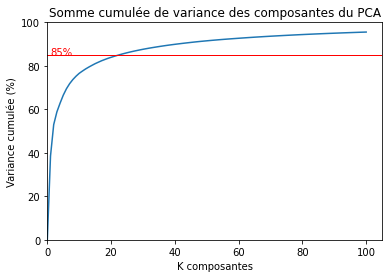

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
var = pca.explainedVariance.cumsum()
sns.lineplot(x=[i for i in range(100+1)], 
             y=np.insert(var, 0, 0)*100)
plt.title('Somme cumulée de variance des composantes du PCA')
plt.xlabel('K composantes')
plt.ylabel('Variance cumulée (%)')
plt.ylim(0, 100)
plt.xlim(left=0)
plt.axhline(85, lw=1, c='red')
plt.text(1, 85, '85%', c='red')
plt.show()

# Sauvegarde des résultats sur  bucket  S3

In [23]:
# Save Spark DataFrame to S3
#https://stackoverflow.com/questions/38154040/save-dataframe-to-csv-directly-to-s3-python
#https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/pca_mnist/pca_mnist.html
from io import StringIO # python3; python2: BytesIO 

bucket = 'ocprojet08r' # already created on S3
csv_buffer = StringIO()
pca_matrix.toPandas().to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'pca_matrix.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'BQVTPCEWXDW5HT9N',
  'HostId': 'ilOTCtYyRue9OdUW8bYbFPzWimBlnOcjRW/FTU69d+lp8/lsw9WGt3xqXcMJi8aCltUd0uBf7ZY=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'ilOTCtYyRue9OdUW8bYbFPzWimBlnOcjRW/FTU69d+lp8/lsw9WGt3xqXcMJi8aCltUd0uBf7ZY=',
   'x-amz-request-id': 'BQVTPCEWXDW5HT9N',
   'date': 'Fri, 14 Jan 2022 08:43:44 GMT',
   'etag': '"18f4ff115ff2ec99e6e0a61d866d2593"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"18f4ff115ff2ec99e6e0a61d866d2593"'}

In [1]:
!pip install pandas

You should consider upgrading via the 'c:\users\nicol\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.
